In [2]:
import glob
import os
import random
from datetime import datetime

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models

from spec_input_generator import gen, gen_eval
# import spectrogram
# from spectrogram import generate_spec
# from spectrogram import truncate_spec
# from spectrogram import mask_spec
# from spectrogram import add_noise
# from spectrogram import path_to_preprocessing
from spectrogram_class import spectrogram


2022-07-20 14:42:14.111991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 14:42:14.790289: E tensorflow/stream_executor/cuda/cuda_blas.cc:3005] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-07-20 14:42:17.987610: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/shiya/anaconda3/envs/music/lib/
2022-07-20 14:42:17.991150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plug

In [3]:
meta_df = pd.read_csv('../data/OrchideaSOL_metadata.csv')

In [4]:
meta_df.head(2)

,Path,Family (abbr.),Family (in full),Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID (if applicable),Dynamics,Dynamics ID (if applicable),Instance ID,Mute (abbr.),Mute (in full),String ID (if applicable),Needed digital retuning,Fold
0,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,f,3.0,0.0,S,Sordina,NaN,False,2
1,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,p,1.0,0.0,S,Sordina,NaN,True,0


In [5]:
meta_df_dummy = meta_df[['Path', 'Instrument (in full)']]
meta_df_dummy['_ins'] = meta_df_dummy['Instrument (in full)']
meta_df_dummy = pd.get_dummies(meta_df_dummy, columns=['Instrument (in full)'])

In [6]:
meta_df_dummy.head(2)

,Path,_ins,Instrument (in full)_Accordion,Instrument (in full)_Alto Saxophone,Instrument (in full)_Bass Tuba,Instrument (in full)_Bassoon,Instrument (in full)_Cello,Instrument (in full)_Clarinet in Bb,Instrument (in full)_Contrabass,Instrument (in full)_Flute,Instrument (in full)_French Horn,Instrument (in full)_Guitar,Instrument (in full)_Harp,Instrument (in full)_Oboe,Instrument (in full)_Trombone,Instrument (in full)_Trumpet in C,Instrument (in full)_Viola,Instrument (in full)_Violin
0,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Bass Tuba,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Bass Tuba,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
train_df, test_df = train_test_split(meta_df_dummy, stratify=meta_df['Instrument (in full)'], 
                                        train_size=0.8)

In [8]:
train_df.head(2)

,Path,_ins,Instrument (in full)_Accordion,Instrument (in full)_Alto Saxophone,Instrument (in full)_Bass Tuba,Instrument (in full)_Bassoon,Instrument (in full)_Cello,Instrument (in full)_Clarinet in Bb,Instrument (in full)_Contrabass,Instrument (in full)_Flute,Instrument (in full)_French Horn,Instrument (in full)_Guitar,Instrument (in full)_Harp,Instrument (in full)_Oboe,Instrument (in full)_Trombone,Instrument (in full)_Trumpet in C,Instrument (in full)_Viola,Instrument (in full)_Violin
4330,Strings/Contrabass/artificial_harmonic/Cb-art_...,Contrabass,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6148,Strings/Viola/col_legno_battuto/Va-legno_batt-...,Viola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [9]:
list(sorted(set(test_df.sample(1).columns)- set(['Path'])))

['Instrument (in full)_Accordion',
 'Instrument (in full)_Alto Saxophone',
 'Instrument (in full)_Bass Tuba',
 'Instrument (in full)_Bassoon',
 'Instrument (in full)_Cello',
 'Instrument (in full)_Clarinet in Bb',
 'Instrument (in full)_Contrabass',
 'Instrument (in full)_Flute',
 'Instrument (in full)_French Horn',
 'Instrument (in full)_Guitar',
 'Instrument (in full)_Harp',
 'Instrument (in full)_Oboe',
 'Instrument (in full)_Trombone',
 'Instrument (in full)_Trumpet in C',
 'Instrument (in full)_Viola',
 'Instrument (in full)_Violin',
 '_ins']

In [10]:
list(sorted(set(test_df.columns)-set(['Path'])))

['Instrument (in full)_Accordion',
 'Instrument (in full)_Alto Saxophone',
 'Instrument (in full)_Bass Tuba',
 'Instrument (in full)_Bassoon',
 'Instrument (in full)_Cello',
 'Instrument (in full)_Clarinet in Bb',
 'Instrument (in full)_Contrabass',
 'Instrument (in full)_Flute',
 'Instrument (in full)_French Horn',
 'Instrument (in full)_Guitar',
 'Instrument (in full)_Harp',
 'Instrument (in full)_Oboe',
 'Instrument (in full)_Trombone',
 'Instrument (in full)_Trumpet in C',
 'Instrument (in full)_Viola',
 'Instrument (in full)_Violin',
 '_ins']

In [11]:
next(gen(train_df, return_class = True))

(<spectrogram_class.spectrogram at 0x7f47b802b4f0>,
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [12]:
sample = next(gen(train_df))
sample


(array([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        ...,
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [13]:
spec_shape = sample[0].shape
spec_shape

(256, 500, 1)

In [14]:
next(gen_eval(test_df))[0].shape

(256, 500, 1)

In [15]:
tf.data.Dataset.from_generator(lambda: gen(train_df), output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((spec_shape[0], spec_shape[1], 1), (16)))

In [15]:
train_generator = tf.data.Dataset.from_generator(lambda: gen(train_df), output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((spec_shape[0], spec_shape[1], 1), (16)))

: 

In [14]:

BATCH_SIZE = 32 

train_generator = (tf.data.Dataset.from_generator(lambda: gen(train_df), output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((spec_shape[0], spec_shape[1], 1), (16)))).batch(BATCH_SIZE)


In [ ]:
eval_generator = (tf.data.Dataset.from_generator(lambda: gen_eval(test_df), output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((spec_shape[0], spec_shape[1], 1), (16)))).batch(BATCH_SIZE)


In [ ]:
train_generator

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 500, 1), dtype=tf.complex64, name=None), TensorSpec(shape=(None, 16), dtype=tf.int64, name=None))>

In [ ]:

model_2conv = models.Sequential()
model_2conv.add(layers.InputLayer((spec_shape[0], spec_shape[1], 1), dtype = tf.float64))
model_2conv.add(layers.Conv2D(30, (150, 300), activation='relu'))
# , input_shape = (spec_shape[0], spec_shape[1], 1)))
model_2conv.add(layers.MaxPool2D((2, 3)))
model_2conv.add(layers.Conv2D(20, (10, 5), activation = 'relu'))
model_2conv.add(layers.Flatten())
model_2conv.add(layers.Dropout(0.3))
model_2conv.add(layers.Dense(16, activation = 'sigmoid'))
model_2conv.build()

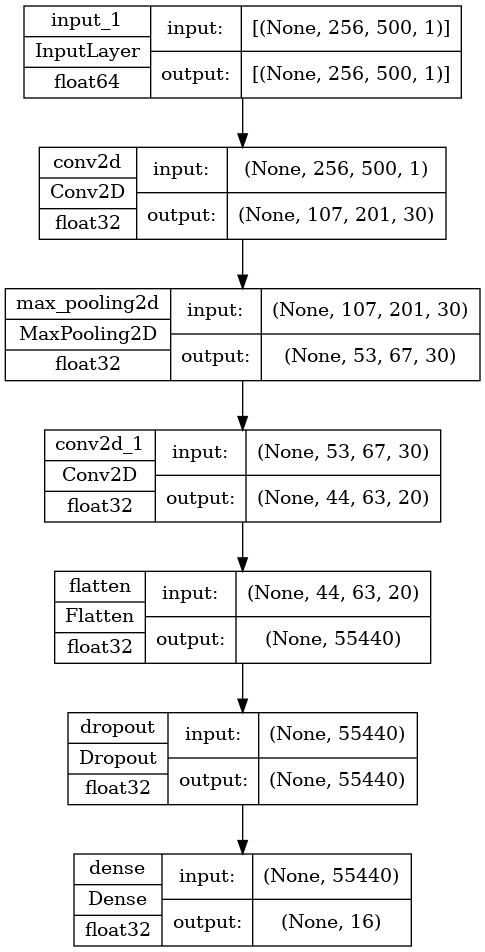

In [ ]:
tf.keras.utils.plot_model(model_2conv, show_shapes = True, show_dtype= True)

In [ ]:

model_2conv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model_2conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 107, 201, 30)      1350030   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 53, 67, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 63, 20)        30020     
                                                                 
 flatten (Flatten)           (None, 55440)             0         
                                                                 
 dropout (Dropout)           (None, 55440)             0         
                                                                 
 dense (Dense)               (None, 16)                887056    
                                                        

In [ ]:
#  model_2conv = tf.keras.models.load_model('../models/baseline_checkpoint/20220719_135009_04_model_2conv')

In [ ]:
model_2conv

In [ ]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/baseline_checkpoint/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_model_2conv", 
                                                    monitor='val_accuracy')
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 2)


history = model_2conv.fit(train_generator, epochs = 5, verbose=1, 
                    steps_per_epoch= int(train_df.shape[0]/BATCH_SIZE), 
                    validation_data = eval_generator,
                    validation_steps = 10, validation_freq= 2, 
                    use_multiprocessing=True, workers = 3, callbacks=[ckpt_callback, early_callback])

Epoch 1/5


2022-07-20 13:03:20.765278: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32768000 exceeds 10% of free system memory.


  1/331 [..............................] - ETA: 6:24:04 - loss: 0.7702 - accuracy: 0.0625

2022-07-20 13:04:29.847027: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32768000 exceeds 10% of free system memory.


  2/331 [..............................] - ETA: 28:03 - loss: 40.2925 - accuracy: 0.0781 

2022-07-20 13:04:35.079703: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32768000 exceeds 10% of free system memory.


  3/331 [..............................] - ETA: 27:56 - loss: 27.7699 - accuracy: 0.1042

2022-07-20 13:04:40.076269: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32768000 exceeds 10% of free system memory.


 43/331 [==>...........................] - ETA: 24:03 - loss: 2.1640 - accuracy: 0.1272

In [ ]:
# model_2conv.save('../models/2conv/fifth/')

INFO:tensorflow:Assets written to: ../models/2conv/fifth/assets


INFO:tensorflow:Assets written to: ../models/2conv/fifth/assets


In [ ]:
history.history['val_accuracy']

[0.48100000619888306, 0.6660000085830688, 0.746999979019165]

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

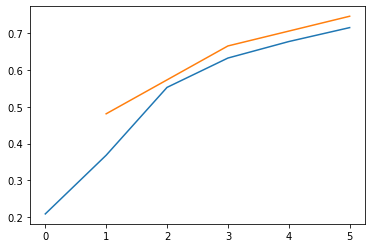

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot([1, 3, 5], history.history['val_accuracy'], label='val_accuracy')